In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
data = pd.read_csv("listings.csv", encoding='utf-8', on_bad_lines='skip')

data.head()


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1139844543126920712,https://www.airbnb.com/rooms/1139844543126920712,20240629050332,2024-06-29,city scrape,Private studio in Zurenborg,Charming private space with a garden in next t...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,116400984,...,5.0,5.0,5.0,NaN,f,1,1,0,0,1.22
1,1153093110246584364,https://www.airbnb.com/rooms/1153093110246584364,20240629050332,2024-06-29,previous scrape,Mooi en lichtrijk appartement,"Relax and unwind in this bright, stylish space...",NaN,https://a0.muscache.com/pictures/hosting/Hosti...,14266081,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
2,1162004759190159606,https://www.airbnb.com/rooms/1162004759190159606,20240629050332,2024-06-29,city scrape,Antwerpstay 11,The accommodation is a 2-person studio located...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,164952192,...,NaN,NaN,NaN,NaN,f,3,3,0,0,NaN
3,1168244754511783859,https://www.airbnb.com/rooms/1168244754511783859,20240629050332,2024-06-29,city scrape,Nice appartement met 4 bedden,Fun with the whole family in this stylish space.,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,22344234,...,NaN,NaN,NaN,NaN,f,4,4,0,0,NaN
4,1171648968667239406,https://www.airbnb.com/rooms/1171648968667239406,20240629050332,2024-06-29,city scrape,Antwerpstay 14,The accommodation is a 2-person studio located...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,164952192,...,NaN,NaN,NaN,NaN,f,3,3,0,0,NaN


In [7]:

missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])
data = data.dropna(subset=['price', 'latitude', 'longitude'])
data['price'] = data['price'].str.replace('$', '').str.replace(',', '').astype(float)
data = data[data['price'] <= data['price'].quantile(0.99)]
data['estimated_monthly_revenue'] = data['price'] * (30 - data['availability_365'] / 12)


description                       68
neighborhood_overview           1277
host_location                    640
host_about                      1551
host_response_time               376
host_response_rate               376
host_acceptance_rate             243
host_is_superhost                 43
host_neighbourhood              2841
neighbourhood                   1277
neighbourhood_group_cleansed    2870
bathrooms                        380
bathrooms_text                     1
bedrooms                          54
beds                             385
price                            424
calendar_updated                2870
has_availability                  50
first_review                     464
last_review                      464
review_scores_rating             464
review_scores_accuracy           467
review_scores_cleanliness        467
review_scores_checkin            467
review_scores_communication      467
review_scores_location           467
review_scores_value              467
l

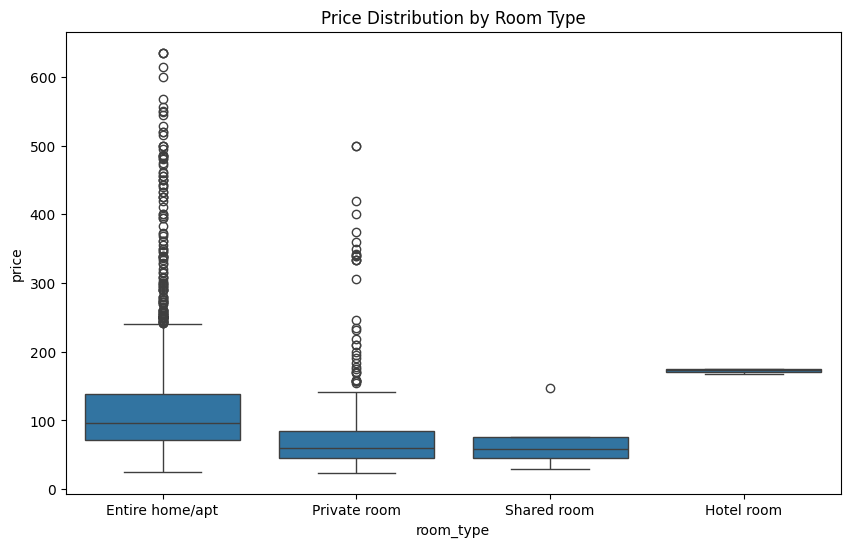

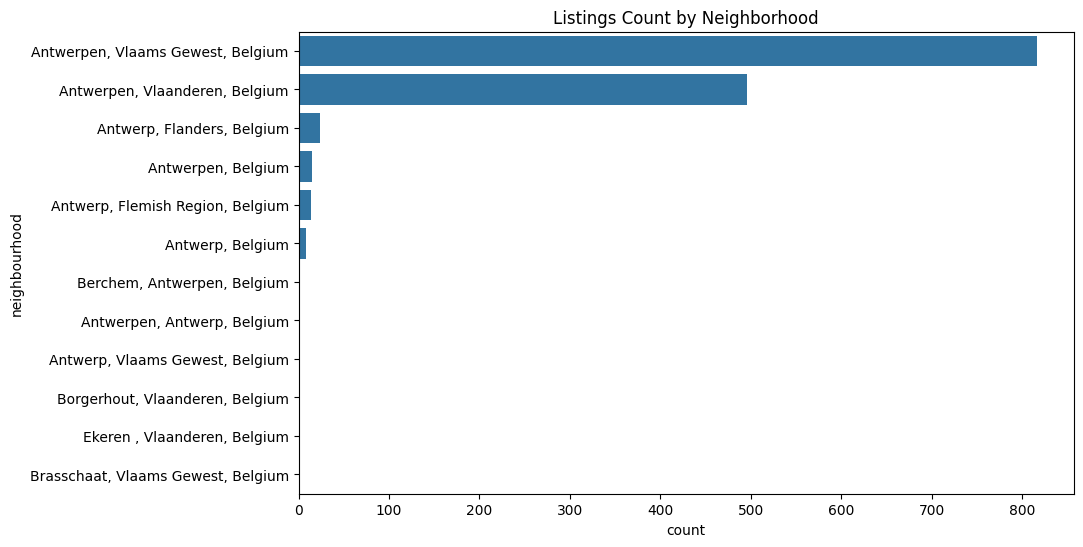

In [9]:
# Price distribution by room type
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='price', data=data)
plt.title('Price Distribution by Room Type')
plt.show()
# Adjust code to match the actual column name
plt.figure(figsize=(10, 6))
sns.countplot(y='neighbourhood', data=data, order=data['neighbourhood'].value_counts().index)
plt.title('Listings Count by Neighborhood')
plt.show()




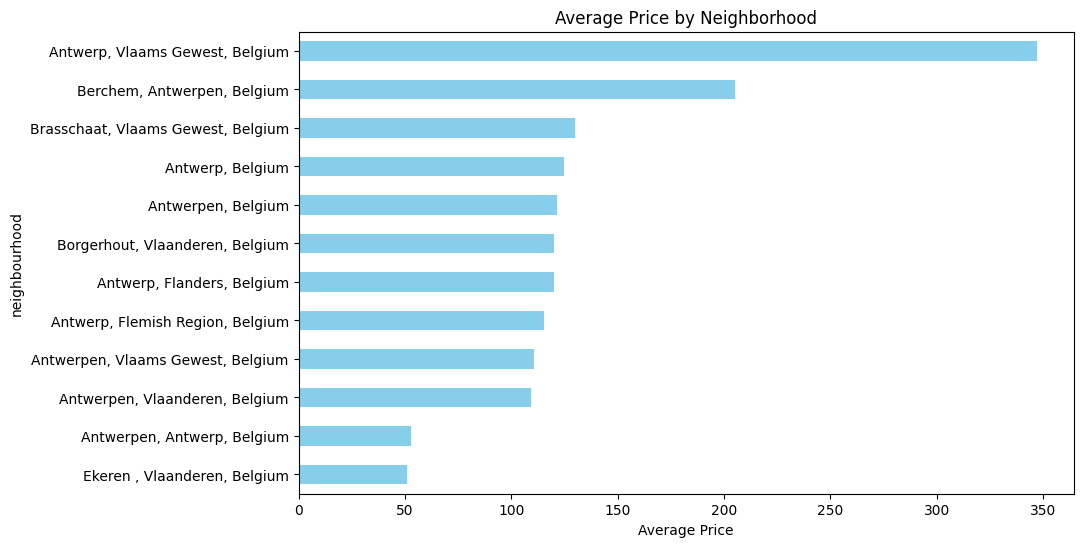

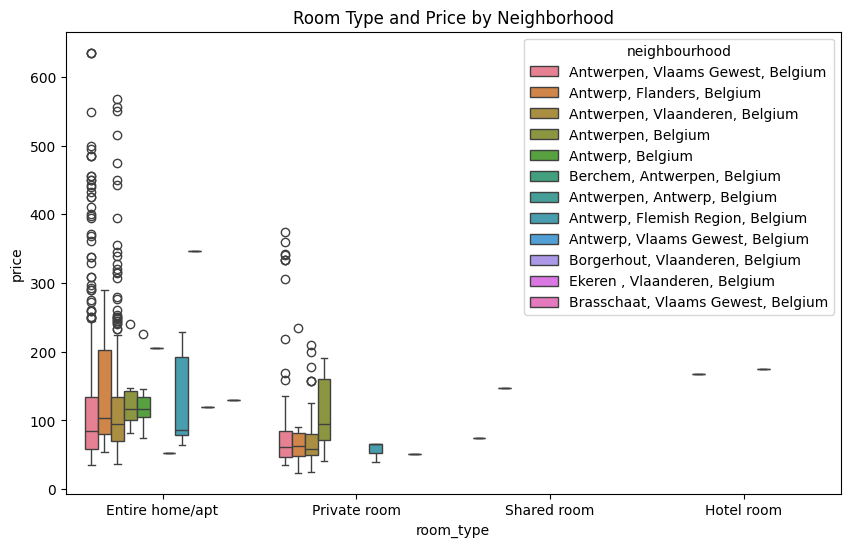

In [11]:
# Adjust if the actual column name is 'neighbourhood'
neighborhood_prices = data.groupby('neighbourhood')['price'].mean().sort_values()

plt.figure(figsize=(10, 6))
neighborhood_prices.plot(kind='barh', color='skyblue')
plt.title('Average Price by Neighborhood')
plt.xlabel('Average Price')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='room_type', y='price', hue='neighbourhood')
plt.title("Room Type and Price by Neighborhood")
plt.show()


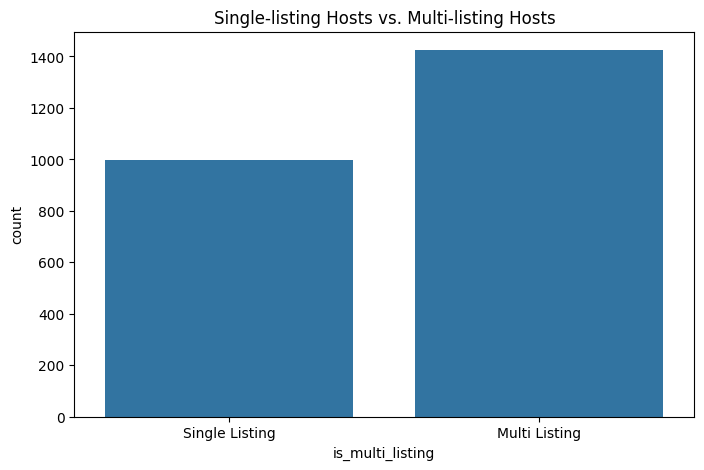

In [12]:
# Count listings per host
host_listing_counts = data['host_id'].value_counts()
data['is_multi_listing'] = data['host_id'].isin(host_listing_counts[host_listing_counts > 1].index)
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='is_multi_listing')
plt.title('Single-listing Hosts vs. Multi-listing Hosts')
plt.xticks([0, 1], ['Single Listing', 'Multi Listing'])
plt.show()


In [13]:
# Create a map centered around NYC
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
heat_data = [[row['latitude'], row['longitude']] for index, row in data.iterrows()]
HeatMap(heat_data).add_to(nyc_map)
nyc_map


In [15]:
# predictive Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
X = pd.get_dummies(data[['room_type']])
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error: ${mae:.2f}")



Mean Absolute Error: $47.83
